# Tratamento dos dados
Nesta etapa será realizado todo o tratamento dos dados, como fazer as transformações de tipo de variável, tratamento de missing, tratamento de outliers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importando os dados
df_vendas = pd.read_csv('../data/raw/sales.csv', index_col=0)
df_estoque_lvl = pd.read_csv('../data/raw/sensor_stock_levels.csv', index_col=0)
df_temperatura = pd.read_csv('../data/raw/sensor_storage_temperature.csv', index_col=0)

### Tratando o timestamp
Conforme visto na documentação, as tabelas podem ser unidas usando o timestamp, mas essa variável é medida de forma diferente nas tabelas, dificultando assim a mesclagem. Para resolver isso irei alterar o timestamp apenas para data e hora sem minutos, pois como definido no problema, os sensores realizarão medidas hora a hora.

Como a transformação funcionará:

06/05/2020 19:45:26 -> 06/05/2020 19:00:00
<br>
09/04/2019 16:10:08 -> 09/04/2019 16:00:00
<br>
19/10/2021 09:30:21 -> 19/10/2021 09:00:00

In [3]:
# Alterando a coluna timestamp
df_vendas['timestamp'] = pd.to_datetime(df_vendas.timestamp.str.slice(0, 13))
df_estoque_lvl['timestamp'] = pd.to_datetime(df_estoque_lvl.timestamp.str.slice(0, 13))
df_temperatura['timestamp'] = pd.to_datetime(df_temperatura.timestamp.str.slice(0, 13))

### Unindo as tabelas

In [4]:
# Unindo as tabelas e verificando o shape
df_vendas.merge(df_estoque_lvl, on = ['product_id', 'timestamp']).shape

(5639, 11)

In [5]:
# Calculando a perda de dados
1 - df_vendas.merge(df_estoque_lvl, on = ['product_id', 'timestamp']).shape[0]/df_vendas.shape[0]

0.27972921190445776

Como a data e hora das vendas são diferentes das datas e hora das medições dos sensores, a união realizada pelo método **merge** está causando uma perda de cerca de 27% dos dados de vendas, o que é bastante.

Para solucionar esse problema, iremos unir os datasets manualmente utilizando o id e data, onde cada item será unido ao percentual de estoque de mesmo timestamp da venda, onde o timestamp anterior à venda será utilizado caso a união anterior não seja feita.

Além disso, como as predições serão feitas de hora em hora, adicionarei o percentual de estoque posterior ao da venda, onde tal dado será o nosso **target**.

In [6]:
# Criando listas vazias
lista_prcnt_estoque_futuro = []
lista_prcnt_estoque_passado = []

# Criando um loop para iterar sob cada indice
for num in range(0, df_vendas.shape[0]):
    
    # Obtendo o id do produto e o timestamp da venda
    timestamp_venda = df_vendas.iloc[num, 1]
    id_produto = df_vendas.iloc[num, 2]
    
    # Encontrando todos os registros de estoque do produto e adicionando o timestamp de venda a ela
    lista_filtrada = df_estoque_lvl.query(f"product_id == '{id_produto}'").timestamp.to_list()
    lista_filtrada_original = lista_filtrada.copy()
    lista_filtrada.append(timestamp_venda)
    
    # Removendo duplicatas e ordenando a lista 
    lista_sem_duplicatas = set(lista_filtrada)
    lista_ordenada = sorted(lista_sem_duplicatas)
    
    # Verificando se o timestamp está na lista
    if timestamp_venda in lista_filtrada_original:
        
        # Se sim, busca o menor lvl de estoque registrado naquela hora
        registro = df_estoque_lvl.query(f"product_id == '{id_produto}' and timestamp == '{timestamp_venda}'")
        registro_ordenado = registro.sort_values('estimated_stock_pct')
        lvl_estoque_passado = registro.estimated_stock_pct.values[0]
        lista_prcnt_estoque_passado.append(lvl_estoque_passado)
            
    else:
        
        # Se não, busca o lvl de estoque do horário passado mais próximo do atual
        try:
            index_novo = lista_ordenada.index(timestamp_venda) - 1
            if index_novo < 0:
                lista_prcnt_estoque_passado.append(np.nan)
            else:
                timestamp_passado = lista_ordenada[index_novo]
                registro = df_estoque_lvl.query(f"product_id == '{id_produto}' and timestamp == '{timestamp_passado}'")
                registro_ordenado = registro.sort_values('estimated_stock_pct')
                lvl_estoque_passado = registro.estimated_stock_pct.values[0]
                lista_prcnt_estoque_passado.append(lvl_estoque_passado)
        
        except:
            lista_prcnt_estoque_passado.append(np.nan)
    
    # Busca o lvl de estoque da hora seguinte    
    try:    
        index_novo = lista_ordenada.index(timestamp_venda) + 1
        if index_novo > len(lista_ordenada):
            lista_prcnt_estoque_futuro.append(np.nan)
        else:
            timestamp_passado = lista_ordenada[index_novo]
            timestamp_futuro = lista_ordenada[lista_ordenada.index(timestamp_venda) + 1]
            registro = df_estoque_lvl.query(f"product_id == '{id_produto}' and timestamp == '{timestamp_futuro}'")
            registro_ordenado = registro.sort_values('estimated_stock_pct')
            lvl_estoque_futuro = registro.estimated_stock_pct.values[0]
            lista_prcnt_estoque_futuro.append(lvl_estoque_futuro)
        
    except:
        lista_prcnt_estoque_futuro.append(np.nan)
        
# Adiciona os valores a tabela
df_vendas['lvl_estoque_past'] = lista_prcnt_estoque_passado
df_vendas['lvl_estoque_to_predict'] = lista_prcnt_estoque_futuro    

Aqui a nossa abordagem será alterada, pois ao contrário da tabela de estoque, onde tínhamos valores únicos por timestamp devido a diferenciação proporcionada ID, não possuímos a mesma diferenciação aqui, onde cada timestamp possui vários valores diferentes de temperatura associados a ele.

Sendo assim, irei agrupar o timestamp e usarei a coluna de temperatura par calcular algumas estatísticas para cada horário, como média, mediana, etc. É necessário valores únicos para uma união sem perda de valor entre as tabelas.

In [7]:
# Computando estatísticas e resetando o index
df_temperatura = df_temperatura.groupby('timestamp').temperature.agg(['mean', 'median', 'min', 'max', 'std', 'var'])
df_temperatura = df_temperatura.reset_index()

In [8]:
# Unindo as  e salvando os dados
df_unido = df_vendas.merge(df_temperatura, on = 'timestamp')
df_unido.to_csv('../data/interim/dados_unidos.csv')

In [9]:
# Checando o resultado da união
df_unido.head()

,transaction_id,timestamp,product_id,category,customer_type,unit_price,quantity,total,payment_type,lvl_estoque_past,lvl_estoque_to_predict,mean,median,min,max,std,var
0,a1c82654-c52c-45b3-8ce8-4c2a1efe63ed,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,gold,3.99,2,7.98,e-wallet,0.37,0.48,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935
1,c7efb312-1956-4185-875a-cd6c3714e127,2022-03-02 09:00:00,3bc6c1ea-0198-46de-9ffd-514ae3338713,fruit,premium,3.99,3,11.97,credit card,0.37,0.48,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935
2,514ea59d-3f6b-42e4-9b48-eb7a45126361,2022-03-02 09:00:00,14736243-d346-438f-9535-d80fcb9f3882,fruit,premium,1.49,4,5.96,e-wallet,0.54,0.33,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935
3,34ba9d8c-bd75-4533-920d-dd5164865305,2022-03-02 09:00:00,ad81b46c-bf38-41cf-9b54-5fe7f5eba93e,fruit,non-member,3.99,3,11.97,cash,0.51,0.04,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935
4,ba2b8370-9980-49cd-be8d-a2a974f05a96,2022-03-02 09:00:00,7f5e86e6-f06f-45f6-bf44-27b095c9ad1d,fruit,premium,4.49,2,8.98,credit card,0.71,0.98,-0.6729,-1.26,-30.58,34.33,11.456305,131.246935


### Criando novas features
Agora que já possuímos um dataset completo, vou criar mais algumas feature a partir dos dados de tempo e dropar os id's.

In [10]:
# Buscando o dia da semana
df_unido['day_of_week'] = df_unido.timestamp.dt.weekday

# Buscando se é final de semana
df_unido['is_weekend'] = df_unido.day_of_week.apply(lambda day: 'yes' if day > 4 else 'no')

# Buscando a hora e turno
df_unido['hour'] = df_unido.timestamp.dt.hour
df_unido['turn'] = df_unido.hour.apply(lambda hour: 'morning' if hour < 12 else ('afternoon' if 12 <= hour < 18 else 'night'))

### Investigando Outliers
Como vimos na etapa de EDA, existem alguns outliers nas colunas **total** e **unit_price**.

In [11]:
# Calculando os quartis e o IQR
q1 = np.quantile(df_unido.total, 0.25)
q3 = np.quantile(df_unido.total, 0.75)
iqr = q3 - q1

#Separando os dados sem e com outliers
dados_com_outliers = df_unido.query(f"total > {q3 + 1.5 * iqr}")
dados_sem_outliers = df_unido.query(f"total < {q3 + 1.5 * iqr}")

In [12]:
# Verificando a quantidade
dados_com_outliers.shape[0]

300

(array([1904., 1520., 1248.,  804.,  610.,  499.,  394.,  253.,  142.,
         155.]),
 array([ 0.19 ,  6.247, 12.304, 18.361, 24.418, 30.475, 36.532, 42.589,
        48.646, 54.703, 60.76 ]),
 <BarContainer object of 10 artists>)

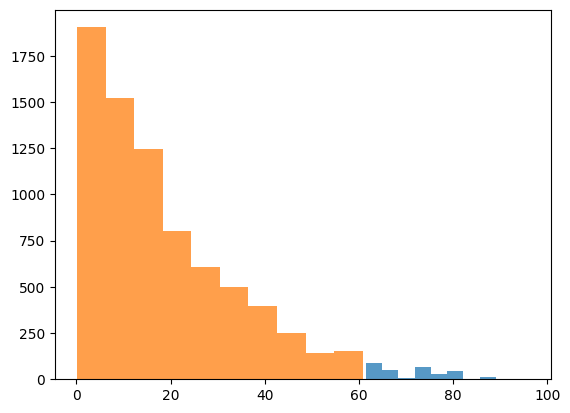

In [13]:
# Verificando as distribuições
plt.hist(dados_com_outliers.total, alpha = 0.75)
plt.hist(dados_sem_outliers.total, alpha = 0.75)

 A distribuição dos dados é relativamente próxima, não existindo outliers discrepantes.

In [14]:
print(f"O preço médio por unidade dos dados sem outliers é de: {dados_sem_outliers.unit_price.mean()}")
print(f"O preço médio por unidade dos dados com outliers é de: {dados_com_outliers.unit_price.mean()}")


O preço médio por unidade dos dados sem outliers é de: 7.392111834240934
O preço médio por unidade dos dados com outliers é de: 18.545


 diferença no preço é relativamente alta.

In [15]:
print(f"A quantidade média de itens comprados nos dados sem outliers é de: {dados_sem_outliers.quantity.mean()}")
print(f"A quantidade média de itens comprados nos dados com outliers é de: {dados_com_outliers.quantity.mean()}")

A quantidade média de itens comprados nos dados sem outliers é de: 2.4466728649223004
A quantidade média de itens comprados nos dados com outliers é de: 3.88


A quantidade de itens comprados também possui uma diferença significativa.

In [16]:
# Calculando os quartis e o IQR
q1 = np.quantile(df_unido.unit_price, 0.25)
q3 = np.quantile(df_unido.unit_price, 0.75)
iqr = q3 - q1

#Separando os dados sem e com outliers
dados_com_outliers = df_unido.query(f"unit_price > {q3 + 1.5 * iqr}")
dados_sem_outliers = df_unido.query(f"unit_price < {q3 + 1.5 * iqr}")

In [17]:
# Verificando a quantidade
dados_com_outliers.shape[0]

31

(array([1276., 1189., 1144., 1234.,  897.,  610.,  391.,  471.,  273.,
         296.]),
 array([ 0.19,  2.27,  4.35,  6.43,  8.51, 10.59, 12.67, 14.75, 16.83,
        18.91, 20.99]),
 <BarContainer object of 10 artists>)

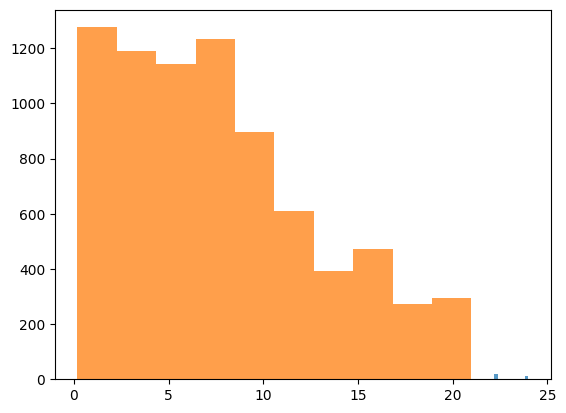

In [18]:
# Verificando as distribuições
plt.hist(dados_com_outliers.unit_price, alpha = 0.75)
plt.hist(dados_sem_outliers.unit_price, alpha = 0.75)

Levando em consideração que as unidades mais caras estão bem próximas das não consideradas outliers, e que compras com outliers são aquelas que possuem os produtos mais caros e que são levados em uma quantidade próxima ao máximo registrado, posso concluir que os outliers são naturais. Removê-los ou tratar como uma inconsistência atrapalharia no aprendizado do modelo.

### Dropando colunas
Nesta etapa irei deletar algumas colunas que não agregam valor, como id's e timestamp.

In [19]:
# Excluindo as colunas
df_unido = df_unido.drop(columns=['transaction_id', 'product_id', 'timestamp'])

Levando em conta que não temos mais mais tratamentos para aplicar, não possuímos valores missing e nem duplicatas ou inconsistências, irei utilizar a última versão do dataset para construir um modelo de Machine Learning. Entretanto, como novas variáveis foram criadas, irei checar as relações e correlações em busca de insights.

### Checando correlações e relacionamentos

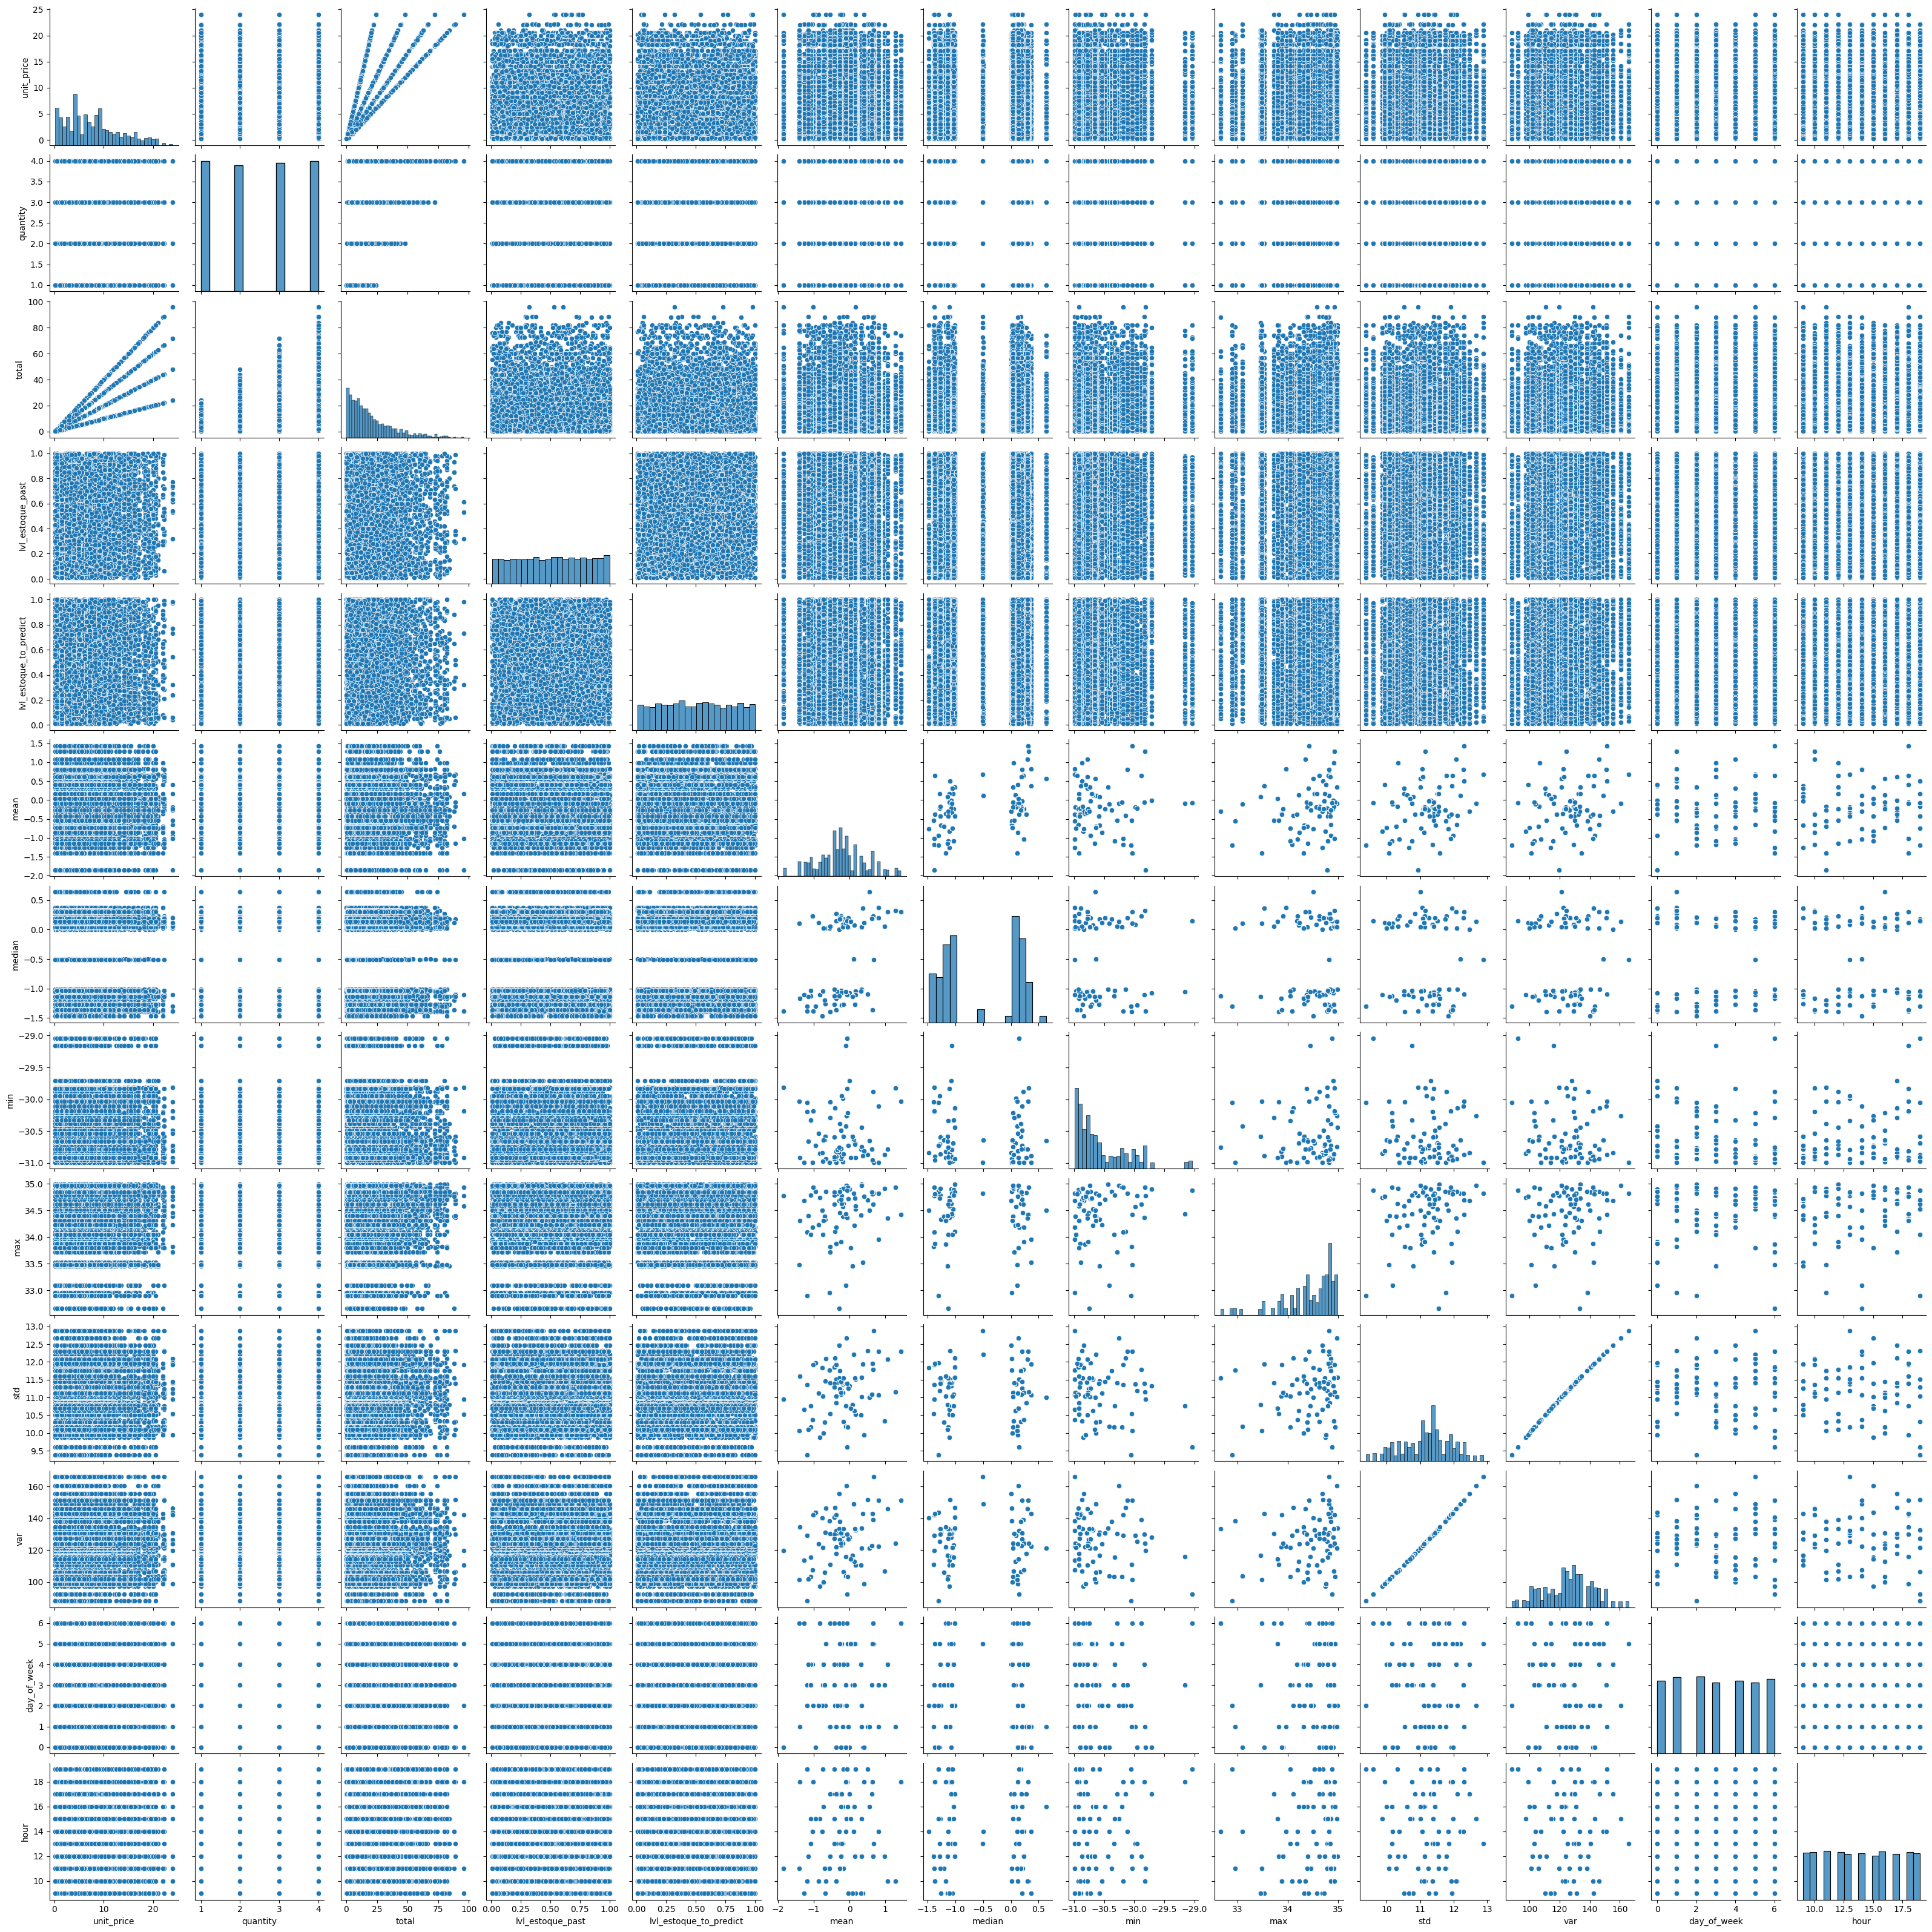

In [20]:
# Checando as relações entre variáveis numéricas
sns.pairplot(df_unido)

<Axes: >

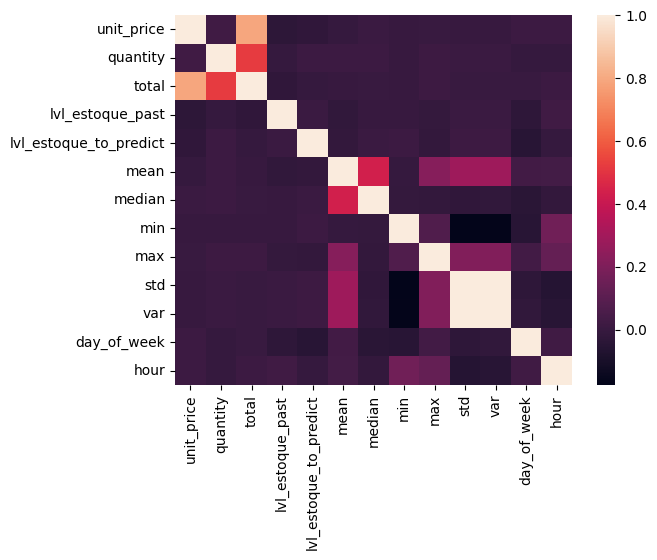

In [21]:
# Checando as correlações
sns.heatmap(df_unido.corr(numeric_only=True))

### Checando valores ausentes
Já era esperado que dados ausentes fossem produzidos a partir da união das tabelas, pois vendas que ocorreram na primera hora do primeiro dia não possuem dados de estoque anteriores a essa data, além da não disponibilidade de dados target para serem utilizados nas vendas do ultimo dia durante o ultimo horário.

A partir disso, irei dropar os dados que possuem nulo no target. As variáveis explicativas que possuem missing serão mantidas. 

In [27]:
# Verificando a % de valores ausentes
round((df_unido.isna().sum()/df_unido.shape[0] * 100), 2)

category                  0.0
customer_type             0.0
unit_price                0.0
quantity                  0.0
total                     0.0
payment_type              0.0
lvl_estoque_past          0.0
lvl_estoque_to_predict    0.0
mean                      0.0
median                    0.0
min                       0.0
max                       0.0
std                       0.0
var                       0.0
day_of_week               0.0
is_weekend                0.0
hour                      0.0
turn                      0.0
dtype: float64

Como representa menos de 2% de mjissing, irei dropar os valores ausentes da coluna **lvl_estoque_past** também.

In [26]:
# Dropando os registros
df_unido = df_unido.dropna()

### Salvando dados finais

In [28]:
# Salvando os dados
df_unido.to_csv('../data/interim/dados_para_treino.csv')